# Introduction

In this notebook, we explore different ML models to predict final outcome of a module-presentation for a student.

In [2]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Read the merged CSV file
In this section, we will read the CSV that stores the merged data relevant for our analysis.

Sanity check:
1. 28,875 rows
2. 16 columns

In [4]:
# Read the CSV 

df = pd.read_csv("../data/merged.csv", index_col=0)
df

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_click,mean,max,min
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,934.0,82.000000,85.0,78.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1435.0,66.400000,70.0,60.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0,76.000000,94.0,59.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2158.0,76.000000,88.0,71.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1034.0,54.400000,75.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28780,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,41.0,76.000000,94.0,59.0
28781,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,893.0,88.111111,100.0,72.0
28782,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,312.0,76.666667,100.0,60.0
28783,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,275.0,91.500000,100.0,83.0


In [5]:
# Replace the data item '55<=' in 'age_band' column with '55+' as '<' and '=' chars are not accepted in some models
df.replace({'age_band': {'55<=': '55+'}}, inplace=True)

# Replace value '10-20' in 'imd_band' column with '10-20%' for input data consistency
df.replace({'imd_band': {'10-20': '10-20%'}}, inplace=True)

df.imd_band.value_counts()

20-30%     3200
10-20%     3132
30-40%     3128
0-10%      2944
40-50%     2890
50-60%     2787
60-70%     2560
70-80%     2532
80-90%     2421
90-100%    2220
Missing     971
Name: imd_band, dtype: int64

### Prepare the independent and dependent variables

In [6]:
# Prepare the depedent variable by replacing categorical values with numerical values

di = {'Pass':1, 'Distinction': 1, 'Withdrawn': 0, 'Fail':0}
df['final_result'] = df['final_result'].map(di)
df.final_result.value_counts()

0    15307
1    13478
Name: final_result, dtype: int64

In [7]:
df.final_result.value_counts(normalize=True)

0    0.53177
1    0.46823
Name: final_result, dtype: float64

In [8]:
# Prepare the independent variables: we'll drop 'id_student' and highest_education' columns from analysis

categorical = ['code_module', 'code_presentation', 'gender', 'region', 'imd_band', 'age_band', 'disability']
numerical = ['num_of_prev_attempts', 'studied_credits', 'sum_click', 'mean', 'max', 'min']

df.drop( ['id_student', 'highest_education'], axis=1, inplace=True)

df.columns

Index(['code_module', 'code_presentation', 'gender', 'region', 'imd_band',
       'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability',
       'final_result', 'sum_click', 'mean', 'max', 'min'],
      dtype='object')

### Split your indepedent and dependent variables into train and test sets

We'll be using a train/val/test split, using the train_test_split function. We will also stratify by y so that the proportions for our dependent variables are even.

In [9]:
# Split your data into train, val, and test sets

from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11, stratify=df['final_result'])
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11, stratify=df_full_train['final_result'])

print( df_train.shape, df_val.shape, df_test.shape )

print( df_train.final_result.value_counts(), df_train.final_result.value_counts(normalize=True) )
print( df_val.final_result.value_counts(),  df_val.final_result.value_counts(normalize=True) )
print( df_test.final_result.value_counts(),  df_test.final_result.value_counts(normalize=True) )

(17271, 14) (5757, 14) (5757, 14)
0    9185
1    8086
Name: final_result, dtype: int64 0    0.531816
1    0.468184
Name: final_result, dtype: float64
0    3061
1    2696
Name: final_result, dtype: int64 0    0.531701
1    0.468299
Name: final_result, dtype: float64
0    3061
1    2696
Name: final_result, dtype: int64 0    0.531701
1    0.468299
Name: final_result, dtype: float64


In [10]:
# separate the independent and dependent data, and drop indexes

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.final_result
y_val = df_val.final_result
y_test = df_test.final_result

del df_train['final_result']
del df_val['final_result']
del df_test['final_result']

In [11]:
# one-hot encoding for categorical independent variables; resulting matrix should have 48 columns
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train.fillna(0).to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.fillna(0).to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

test_dict = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dict)

In [12]:
X_train.shape, X_val.shape, X_test.shape

((17271, 48), (5757, 48), (5757, 48))

### Train machine learning models

In [13]:
from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

F1 score: 0.475
ROC score: 0.494


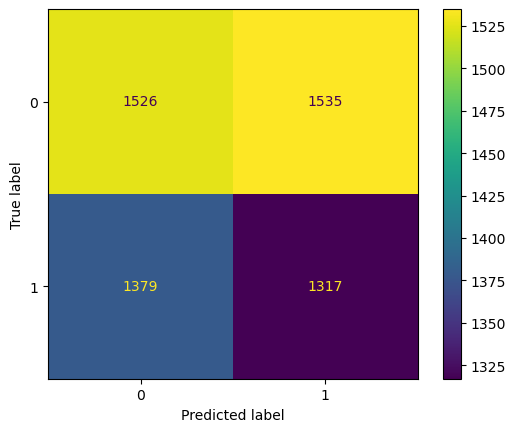

In [14]:
# Declare a variable to store the dummy model
dummy_clf = DummyClassifier(strategy='uniform')

# Fit your train dataset
dummy_clf.fit(X_train, y_train)

# Declare a variable and store your predictions that you make with your model using X test data
y_pred = dummy_clf.predict(X_val)

# Print the f1_score between y_test and your prediction
print(f'F1 score: { round( f1_score(y_val, y_pred), 3) }' )
print(f'ROC score: { round( roc_auc_score(y_val, y_pred), 3 ) }' )

# Print the confusion matrix between y_test and your prediction
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy_clf.classes_)
disp.plot()

### LogisticRegression


F1 score: 0.83
AUC score: 0.842


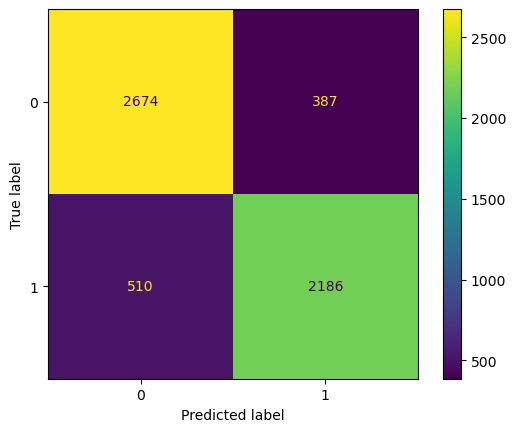

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

# feature scaling for convergence in optimization, as model uses L2 regularization
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)


# Step 7a: Declare a variable to store the model
model = LogisticRegression(solver='lbfgs', random_state=11)

# Step 7b: Fit your train dataset
model.fit(X_train_scaled, y_train)

# Step 7c: Declare a variable and store your predictions that you make with your model using X test data
prob_pred = model.predict_proba(X_val_scaled)[:, 1]
y_pred = (prob_pred >= 0.5).astype(int)

# Step 7d: Print the f1_score between y_test and your prediction
print(f'F1 score: { round( f1_score(y_val, y_pred), 3) }' )

print(f'AUC score: { round( roc_auc_score(y_val, y_pred), 3 ) }' )

# Step 7e: Print the confusion matrix between y_test and your prediction
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [16]:
# display the logistic regression model weights
# sort the weights in descending order of absolute values
# to see which features are most influential in predicting final_result

model_wts = dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))
sorted_mw = sorted(model_wts.items(), key=lambda x:np.abs(x[1]), reverse=True)
sorted_mw

[('sum_click', 3.105),
 ('mean', 0.98),
 ('code_module=FFF', -0.69),
 ('min', -0.628),
 ('max', 0.555),
 ('code_module=BBB', 0.371),
 ('code_module=AAA', 0.294),
 ('code_module=GGG', 0.279),
 ('code_module=CCC', -0.162),
 ('code_presentation=2013B', -0.162),
 ('code_module=DDD', 0.14),
 ('studied_credits', -0.12),
 ('imd_band=0-10%', -0.096),
 ('age_band=0-35', 0.089),
 ('imd_band=Missing', 0.085),
 ('imd_band=90-100%', 0.083),
 ('age_band=35-55', -0.079),
 ('imd_band=10-20%', -0.078),
 ('code_presentation=2014J', 0.068),
 ('num_of_prev_attempts', -0.063),
 ('age_band=55+', -0.059),
 ('imd_band=20-30%', -0.056),
 ('region=West Midlands Region', -0.044),
 ('imd_band=60-70%', 0.041),
 ('region=East Anglian Region', 0.038),
 ('code_presentation=2013J', 0.036),
 ('region=South West Region', 0.036),
 ('code_module=EEE', 0.035),
 ('region=South Region', 0.032),
 ('region=South East Region', 0.031),
 ('disability=N', 0.029),
 ('disability=Y', -0.029),
 ('region=North Western Region', -0.029),

Just as we saw from EDA, the features that impact the final outcome are sum_click and mean assessment score.

### DecisionTreeClassifier

We'll see whether DecisionTreeClassifier can further improve the performance of LogisticRegression.

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [18]:
# Find the values of parameters max_depth and min_samples_leaf
# which will give optimal AUC score

scores = []

for depth in [4, 5, 6, 8, 10, 12, 15]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, random_state=11)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))
        
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)


auc                                          
max_depth            4      5      6      8      10     12     15
min_samples_leaf                                                 
1                 0.902  0.911  0.913  0.915  0.907  0.879  0.843
5                 0.902  0.912  0.915  0.922  0.915  0.903  0.893
10                0.902  0.912  0.914  0.922  0.920  0.914  0.910
15                0.902  0.912  0.915  0.923  0.923  0.921  0.919
20                0.902  0.912  0.915  0.924  0.926  0.923  0.923
100               0.903  0.913  0.920  0.923  0.923  0.924  0.924
200               0.903  0.911  0.917  0.920  0.921  0.921  0.921
500               0.901  0.906  0.906  0.909  0.909  0.909  0.909

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

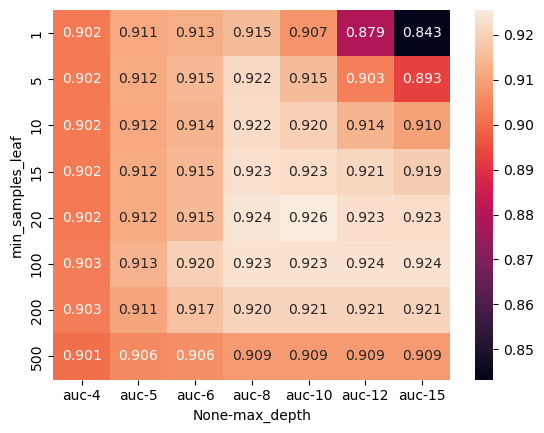

In [19]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [20]:
# For best auc score of 0.926, we select max_depth=10 and min_samples_leaf=20

dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, random_state=11)
dt.fit(X_train, y_train)

# display the decision tree to see which features are most important
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- sum_click <= 413.50
|   |--- max <= 99.50
|   |   |--- sum_click <= 212.50
|   |   |   |--- min <= 51.50
|   |   |   |   |--- code_module=BBB <= 0.50
|   |   |   |   |   |--- sum_click <= 172.50
|   |   |   |   |   |   |--- studied_credits <= 165.00
|   |   |   |   |   |   |   |--- code_module=GGG <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- code_module=GGG >  0.50
|   |   |   |   |   |   |   |   |--- min <= 43.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- min >  43.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- studied_credits >  165.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- sum_click >  172.50
|   |   |   |   |   |   |--- mean <= 62.38
|   |   |   |   |   |   |   |--- code_presentation=2014J <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- code_presentation=2014J >  0.50
|   |   |   |   |   |   

/Users/pllee/opt/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### RandomForestClassifier

Next up, we will use a RandomForestClassifier.

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
# Parameter search over values of max_depth and num_estimators

scores = []

for d in [5, 10, 15, 20]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

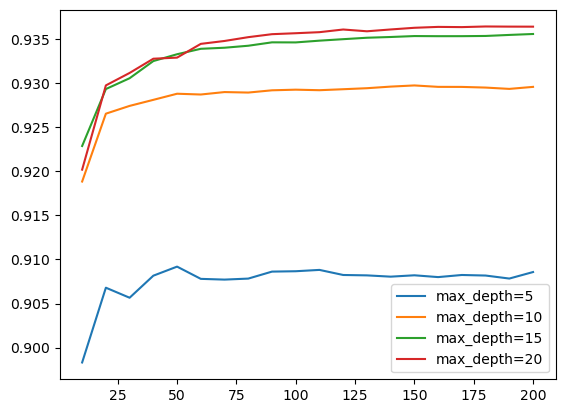

In [23]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

for d in [5, 10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [24]:
# Since the improvement in AUC score for max_depth=20 over max_depth=15 is not too great, we choose
# to fix max_depth at 15 for a simpler model
max_depth = 15

In [25]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))     

In [26]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

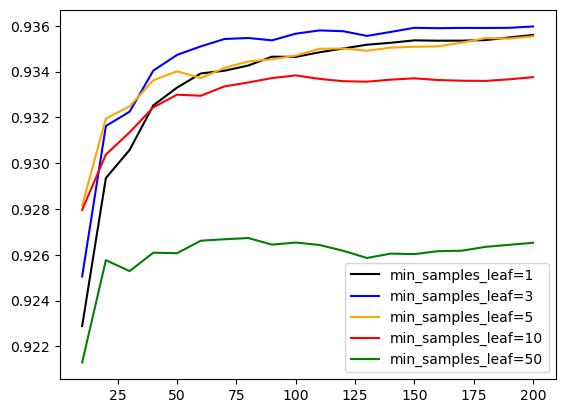

In [27]:
colors = ['black', 'blue', 'orange', 'red', 'green']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [28]:
# We select min_samples_leaf=5; its curve rises higher than the others except that of min_samples_leaf=3,
# but the 2 highest curves are not that far apart.  So we pick the larger value i.e. min_samples_leaf=5,
# and select n_estimators = 100

min_samples_leaf = 5

rf = RandomForestClassifier(n_estimators=100,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=5, random_state=1)

In [29]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9346985915465651

In [30]:
# Print the feature importances for the RF model

fi = dict(zip(dv.get_feature_names_out(), rf.feature_importances_.round(3)))
sorted_fi = sorted(fi.items(), key=lambda x:x[1], reverse=True)
sorted_fi

[('sum_click', 0.36),
 ('mean', 0.214),
 ('max', 0.185),
 ('min', 0.105),
 ('studied_credits', 0.013),
 ('code_module=FFF', 0.011),
 ('code_module=BBB', 0.009),
 ('code_module=AAA', 0.007),
 ('code_module=CCC', 0.007),
 ('code_presentation=2014J', 0.006),
 ('gender=F', 0.006),
 ('code_module=GGG', 0.005),
 ('code_module=DDD', 0.004),
 ('code_presentation=2013B', 0.004),
 ('gender=M', 0.004),
 ('num_of_prev_attempts', 0.004),
 ('age_band=0-35', 0.003),
 ('age_band=35-55', 0.003),
 ('code_presentation=2013J', 0.003),
 ('code_presentation=2014B', 0.003),
 ('imd_band=0-10%', 0.003),
 ('imd_band=10-20%', 0.003),
 ('code_module=EEE', 0.002),
 ('disability=N', 0.002),
 ('disability=Y', 0.002),
 ('imd_band=20-30%', 0.002),
 ('imd_band=30-40%', 0.002),
 ('imd_band=90-100%', 0.002),
 ('imd_band=Missing', 0.002),
 ('region=East Anglian Region', 0.002),
 ('region=North Western Region', 0.002),
 ('region=Scotland', 0.002),
 ('region=South Region', 0.002),
 ('region=Wales', 0.002),
 ('imd_band=40-50

In [ ]:
# So then, we see that the RF says that sum_click has the largest importance value, followed by the assessment stats, while the
# rest of the features are much less important in comparison.

### XGBoostClassifier


In [40]:
import xgboost as xgb

In [41]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [42]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [43]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [44]:
scores={}

In [57]:
%%capture output

xgb_params = {
    'eta': 0.05, 
    'max_depth': 7,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [58]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.05'

In [59]:
scores

{'eta=0.3':     num_iter  train_auc  val_auc
 0          0    0.93612  0.91991
 1          5    0.95185  0.93566
 2         10    0.95631  0.93795
 3         15    0.95998  0.93825
 4         20    0.96468  0.93839
 5         25    0.96777  0.93905
 6         30    0.97119  0.93903
 7         35    0.97461  0.93846
 8         40    0.97689  0.93830
 9         45    0.97917  0.93800
 10        50    0.98116  0.93824
 11        55    0.98324  0.93785
 12        60    0.98502  0.93786
 13        65    0.98647  0.93818
 14        70    0.98788  0.93779
 15        75    0.98886  0.93760
 16        80    0.98995  0.93767
 17        85    0.99178  0.93770
 18        90    0.99203  0.93764
 19        95    0.99285  0.93732
 20       100    0.99330  0.93702
 21       105    0.99402  0.93674
 22       110    0.99488  0.93645
 23       115    0.99508  0.93623
 24       120    0.99578  0.93594
 25       125    0.99639  0.93565
 26       130    0.99687  0.93554
 27       135    0.99728  0.93512
 28

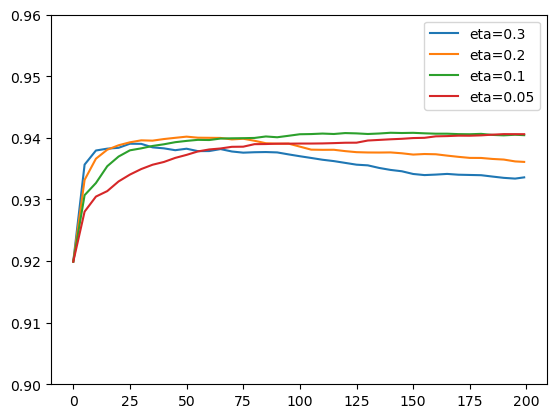

In [60]:
for eta, df_score in scores.items():
    #print(f'eta: {eta}')
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.ylim(0.9, 0.96)
plt.legend()

In [61]:
# Based on the above graph, we select eta=0.1 and boost_round=150
xgb_params = {
    'eta': 0.1, 
    'max_depth': 7,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=150,
                  verbose_eval=5,
                  evals=watchlist)
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

[0]	train-auc:0.93612	val-auc:0.91991
[5]	train-auc:0.94531	val-auc:0.93070
[10]	train-auc:0.94829	val-auc:0.93267
[15]	train-auc:0.95127	val-auc:0.93540
[20]	train-auc:0.95367	val-auc:0.93697
[25]	train-auc:0.95526	val-auc:0.93798
[30]	train-auc:0.95664	val-auc:0.93830
[35]	train-auc:0.95794	val-auc:0.93869
[40]	train-auc:0.95934	val-auc:0.93896
[45]	train-auc:0.96052	val-auc:0.93930
[50]	train-auc:0.96144	val-auc:0.93951
[55]	train-auc:0.96270	val-auc:0.93968
[60]	train-auc:0.96388	val-auc:0.93965
[65]	train-auc:0.96493	val-auc:0.93989
[70]	train-auc:0.96627	val-auc:0.93993
[75]	train-auc:0.96755	val-auc:0.93995
[80]	train-auc:0.96892	val-auc:0.93999
[85]	train-auc:0.96976	val-auc:0.94023
[90]	train-auc:0.97081	val-auc:0.94010
[95]	train-auc:0.97209	val-auc:0.94034
[100]	train-auc:0.97323	val-auc:0.94059
[105]	train-auc:0.97369	val-auc:0.94062
[110]	train-auc:0.97446	val-auc:0.94070
[115]	train-auc:0.97520	val-auc:0.94063
[120]	train-auc:0.97674	val-auc:0.94078
[125]	train-auc:0.9772

0.9408377336395373

In [63]:
# Now we tune the max_depth parameter - 3, 4, 5, 6, 7, 10
scores = {}

In [69]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

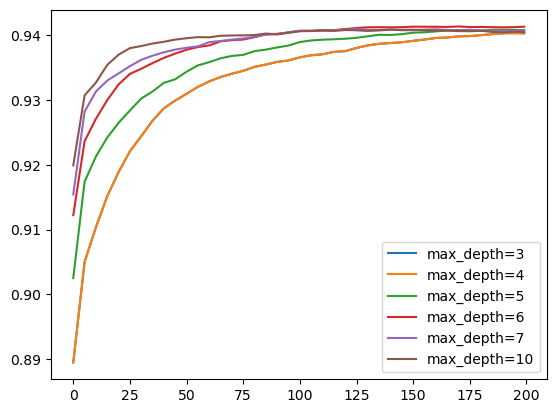

In [70]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

#plt.ylim(0.8, 1.0)
plt.legend()

In [71]:
# It looks like max_depth=6 has highest scores as number of rounds of boosting increases.
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=125,
                  verbose_eval=5,
                  evals=watchlist)
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

[0]	train-auc:0.92961	val-auc:0.91542
[5]	train-auc:0.93993	val-auc:0.92820
[10]	train-auc:0.94268	val-auc:0.93129
[15]	train-auc:0.94503	val-auc:0.93298
[20]	train-auc:0.94691	val-auc:0.93408
[25]	train-auc:0.94822	val-auc:0.93520
[30]	train-auc:0.94971	val-auc:0.93618
[35]	train-auc:0.95102	val-auc:0.93681
[40]	train-auc:0.95224	val-auc:0.93734
[45]	train-auc:0.95299	val-auc:0.93776
[50]	train-auc:0.95413	val-auc:0.93804
[55]	train-auc:0.95553	val-auc:0.93825
[60]	train-auc:0.95655	val-auc:0.93891
[65]	train-auc:0.95737	val-auc:0.93908
[70]	train-auc:0.95836	val-auc:0.93930
[75]	train-auc:0.95929	val-auc:0.93947
[80]	train-auc:0.96054	val-auc:0.93971
[85]	train-auc:0.96153	val-auc:0.94008
[90]	train-auc:0.96260	val-auc:0.94013
[95]	train-auc:0.96364	val-auc:0.94043
[100]	train-auc:0.96422	val-auc:0.94067
[105]	train-auc:0.96495	val-auc:0.94066
[110]	train-auc:0.96581	val-auc:0.94072
[115]	train-auc:0.96644	val-auc:0.94075
[120]	train-auc:0.96717	val-auc:0.94082
[124]	train-auc:0.9677

0.9409411573960529

In [74]:
# Tuning the min_child_weight parameter to improve the auc score to try to be above 0.94094
# We'll test values 1, 10, 20, 30, 50

In [75]:
scores = {}

In [80]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 50,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

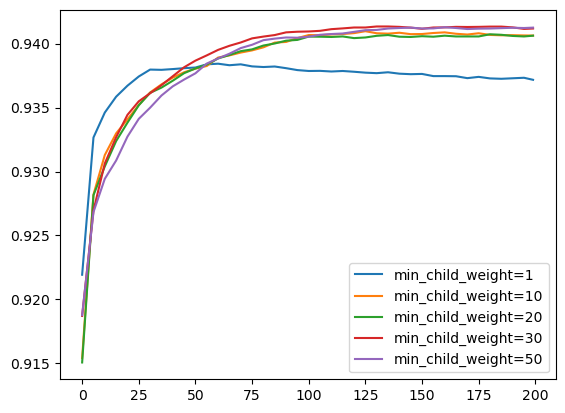

In [81]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

#plt.ylim(0.9, 1.0)
plt.legend()

In [82]:
# The red line looks good.  So we select min_child_weight=30 and num_rounds_boost=130

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=130,
                  verbose_eval=5,
                  evals=watchlist)
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)


[0]	train-auc:0.92871	val-auc:0.91877
[5]	train-auc:0.93603	val-auc:0.92683
[10]	train-auc:0.93834	val-auc:0.92943
[15]	train-auc:0.93993	val-auc:0.93086
[20]	train-auc:0.94156	val-auc:0.93273
[25]	train-auc:0.94282	val-auc:0.93412
[30]	train-auc:0.94361	val-auc:0.93499
[35]	train-auc:0.94460	val-auc:0.93594
[40]	train-auc:0.94554	val-auc:0.93666
[45]	train-auc:0.94650	val-auc:0.93719
[50]	train-auc:0.94751	val-auc:0.93768
[55]	train-auc:0.94850	val-auc:0.93844
[60]	train-auc:0.94926	val-auc:0.93884
[65]	train-auc:0.94999	val-auc:0.93921
[70]	train-auc:0.95078	val-auc:0.93965
[75]	train-auc:0.95142	val-auc:0.93991
[80]	train-auc:0.95205	val-auc:0.94027
[85]	train-auc:0.95252	val-auc:0.94039
[90]	train-auc:0.95300	val-auc:0.94048
[95]	train-auc:0.95358	val-auc:0.94046
[100]	train-auc:0.95393	val-auc:0.94054
[105]	train-auc:0.95435	val-auc:0.94069
[110]	train-auc:0.95469	val-auc:0.94075
[115]	train-auc:0.95508	val-auc:0.94079
[120]	train-auc:0.95545	val-auc:0.94092
[125]	train-auc:0.9558

0.9410659687249469

## Selecting the final model

We select from the tree-based models since logistic regression is underperforming in comparison.

In [83]:
# DecisionTree
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, random_state=11)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, random_state=11)

In [84]:
y_pred = dt.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.9268609247962061

In [85]:
# Random Forest
min_samples_leaf = 5
max_depth = 15

rf = RandomForestClassifier(n_estimators=100,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=5, random_state=1)

In [86]:
y_pred = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.9383510799694055

In [87]:
# XGBoost

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=130,
                  verbose_eval=5,
                  evals=watchlist)

features = dv.get_feature_names_out()
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)


[0]	train-auc:0.92871	val-auc:0.91877
[5]	train-auc:0.93603	val-auc:0.92683
[10]	train-auc:0.93834	val-auc:0.92943
[15]	train-auc:0.93993	val-auc:0.93086
[20]	train-auc:0.94156	val-auc:0.93273
[25]	train-auc:0.94282	val-auc:0.93412
[30]	train-auc:0.94361	val-auc:0.93499
[35]	train-auc:0.94460	val-auc:0.93594
[40]	train-auc:0.94554	val-auc:0.93666
[45]	train-auc:0.94650	val-auc:0.93719
[50]	train-auc:0.94751	val-auc:0.93768
[55]	train-auc:0.94850	val-auc:0.93844
[60]	train-auc:0.94926	val-auc:0.93884
[65]	train-auc:0.94999	val-auc:0.93921
[70]	train-auc:0.95078	val-auc:0.93965
[75]	train-auc:0.95142	val-auc:0.93991
[80]	train-auc:0.95205	val-auc:0.94027
[85]	train-auc:0.95252	val-auc:0.94039
[90]	train-auc:0.95300	val-auc:0.94048
[95]	train-auc:0.95358	val-auc:0.94046
[100]	train-auc:0.95393	val-auc:0.94054
[105]	train-auc:0.95435	val-auc:0.94069
[110]	train-auc:0.95469	val-auc:0.94075
[115]	train-auc:0.95508	val-auc:0.94079
[120]	train-auc:0.95545	val-auc:0.94092
[125]	train-auc:0.9558

0.9434630127079745